<a href="https://colab.research.google.com/github/yuseon-bae/LG_Aimers_7/blob/main/%EC%8B%9D%EC%9D%8C%EC%97%85%EC%9E%A5_%EB%A9%94%EB%89%B4_%EC%88%98%EC%9A%94_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data_path = '/content/drive/MyDrive/Lg_Aimers_data/train'

In [ ]:
import os
import random
import glob
import re

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from tqdm import tqdm


In [ ]:
train = pd.read_csv(f'{train_data_path}/train.csv')
train.columns = ['date', 'store_menu', 'sales_qty']

In [ ]:
print(train.shape)
print(train.head())

(102676, 3)
         date          store_menu  sales_qty
0  2023-01-01  느티나무 셀프BBQ_1인 수저세트          0
1  2023-01-02  느티나무 셀프BBQ_1인 수저세트          0
2  2023-01-03  느티나무 셀프BBQ_1인 수저세트          0
3  2023-01-04  느티나무 셀프BBQ_1인 수저세트          0
4  2023-01-05  느티나무 셀프BBQ_1인 수저세트          0


In [ ]:
# 데이터 타입, 결측치 확인
print(train.info())
print(train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102676 entries, 0 to 102675
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        102676 non-null  object
 1   store_menu  102676 non-null  object
 2   sales_qty   102676 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ MB
None
date          0
store_menu    0
sales_qty     0
dtype: int64


날짜 파생 변수 생성

In [ ]:
# 날짜 컬럼 datetime 변환
train['date'] = pd.to_datetime(train['date'])

# 연/월/일/요일/주말 여부 생성
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['dayofweek'] = train['date'].dt.dayofweek  # Monday=0
train['is_weekend'] = train['dayofweek'].isin([5, 6]).astype(int)

# 영업장명_메뉴명 분리
train[['store', 'menu']] = train['store_menu'].str.split('_', expand=True)

# 4) 음수 매출 제거
train.loc[train['sales_qty'] < 0, 'sales_qty'] = 0

#계절(Season) 컬럼 추가
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

train['season'] = train['month'].apply(get_season)

# 저장된 결과 확인
train.head()

,date,store_menu,sales_qty,year,month,day,dayofweek,is_weekend,store,menu,season
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,2023,1,1,6,1,느티나무 셀프BBQ,1인 수저세트,Winter
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,2023,1,2,0,0,느티나무 셀프BBQ,1인 수저세트,Winter
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,2023,1,3,1,0,느티나무 셀프BBQ,1인 수저세트,Winter
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0,2023,1,4,2,0,느티나무 셀프BBQ,1인 수저세트,Winter
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0,2023,1,5,3,0,느티나무 셀프BBQ,1인 수저세트,Winter


In [ ]:
import matplotlib.pyplot as plt
# 나눔고딕 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum -qq

# 설치된 폰트 확인
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
# print(font_list) # 설치된 폰트 목록 전체를 보려면 주석 해제

# 나눔고딕 설정
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

print("나눔고딕 폰트 설정 완료.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
나눔고딕 폰트 설정 완료.


## 패턴 분석

### 1. 날짜 관련 패턴 분석

,dayofweek,mean,median,sum,count
0,0,7.767453,0.0,113933,14668
1,1,8.528293,0.0,125093,14668
2,2,8.064153,0.0,118285,14668
3,3,9.973275,0.0,146288,14668
4,4,12.255181,1.0,179759,14668
5,5,15.275770,2.0,224065,14668
6,6,12.718639,0.0,186557,14668


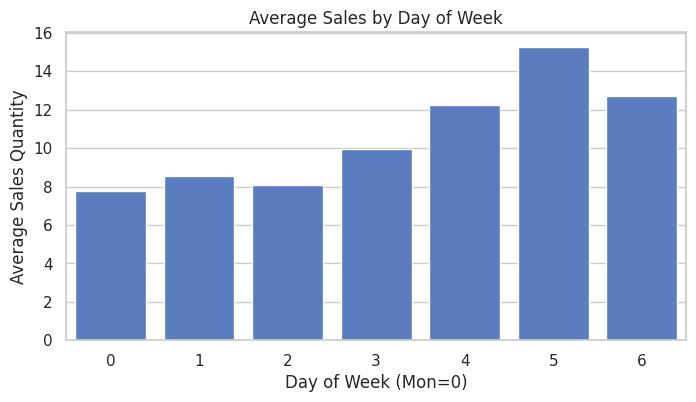

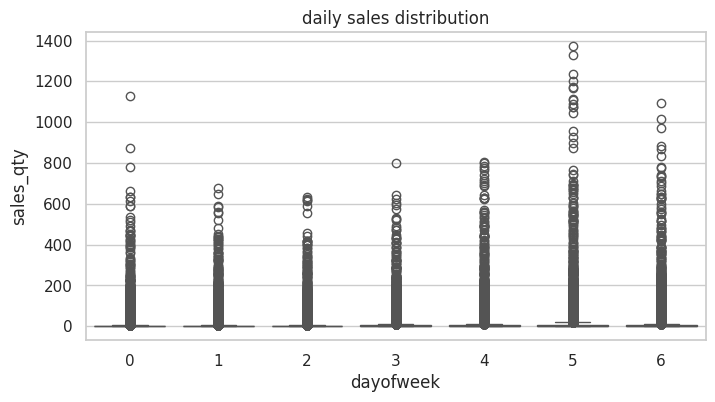

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
plt.rcParams['figure.figsize'] = (10,4)

# 요일별 평균 판매량
weekly = train.groupby('dayofweek')['sales_qty'].agg(['mean','median','sum','count']).reset_index()
display(weekly)

# 시각화
plt.figure(figsize=(8,4))
sns.barplot(data=weekly, x='dayofweek', y='mean')
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week (Mon=0)')
plt.ylabel('Average Sales Quantity')
plt.show()

# Boxplot: 분포 확인 (극단치/중앙값)
plt.figure(figsize=(8,4))
sns.boxplot(data=train, x='dayofweek', y='sales_qty')
plt.title('daily sales distribution')
plt.show()


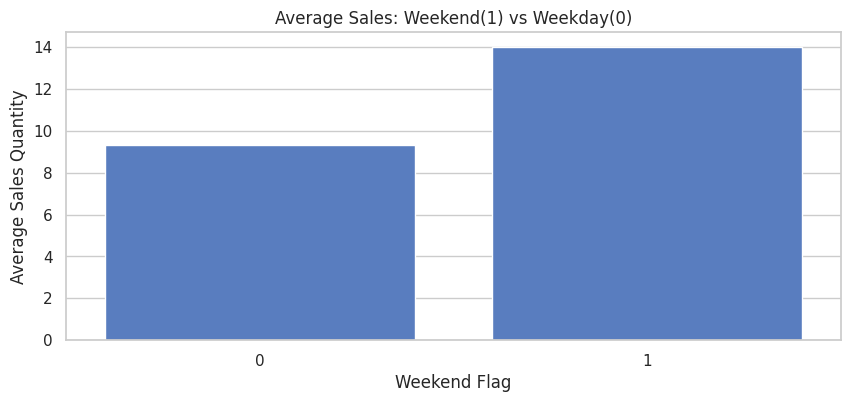

In [ ]:
#주말 vs 평일 평균 판매량
weekend_sales = train.groupby('is_weekend')['sales_qty'].mean().reset_index()
sns.barplot(data=weekend_sales, x='is_weekend', y='sales_qty')
plt.title('Average Sales: Weekend(1) vs Weekday(0)')
plt.xlabel('Weekend Flag')
plt.ylabel('Average Sales Quantity')
plt.show()

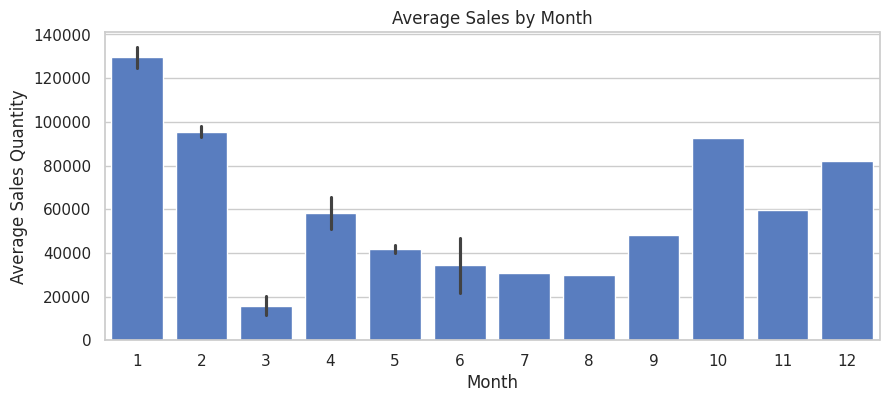

In [ ]:
#월별 평균 판매량
monthly = train.groupby(['year','month'])['sales_qty'].sum().reset_index()
monthly['ym'] = monthly['year'].astype(str) + '-' + monthly['month'].astype(str).str.zfill(2)
monthly = monthly.sort_values('ym')

sns.barplot(data=monthly, x='month', y='sales_qty')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales Quantity')
plt.show()

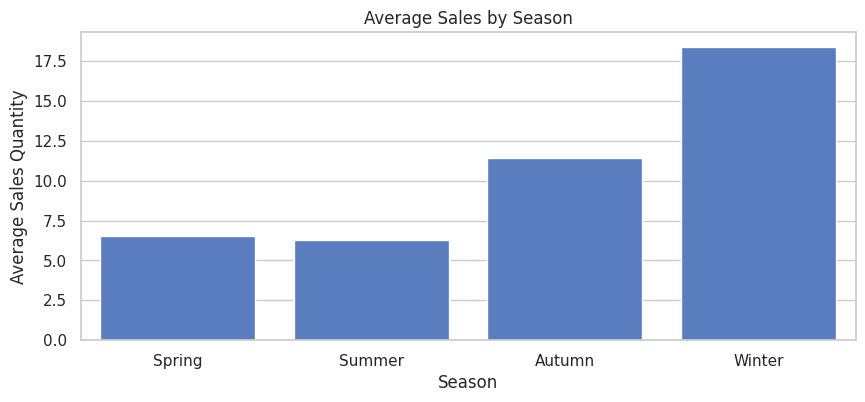

In [ ]:
#계절별 평균 판매량
seasonal = train.groupby('season')['sales_qty'].mean().reset_index()
sns.barplot(data=seasonal, x='season', y='sales_qty',
            order=['Spring', 'Summer', 'Autumn', 'Winter'])
plt.title('Average Sales by Season')
plt.xlabel('Season')
plt.ylabel('Average Sales Quantity')
plt.show()

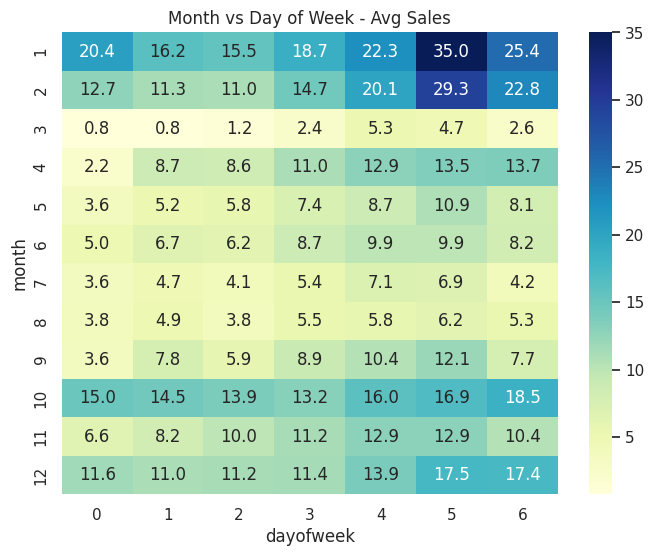

In [ ]:
#요일 × 월 히트맵
pivot = train.pivot_table(index='month', columns='dayofweek',
                          values='sales_qty', aggfunc='mean')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Month vs Day of Week - Avg Sales')
plt.show()

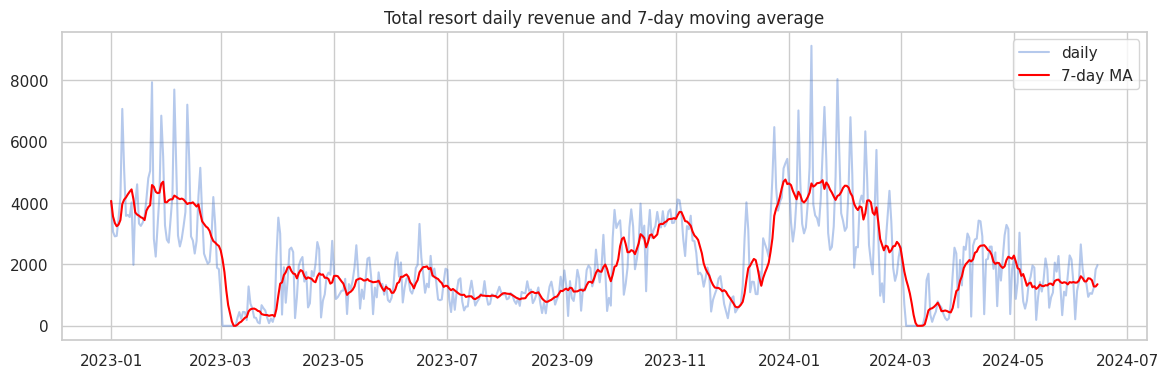

In [ ]:
#전체 일별 시계열(롤링) — 시즌/추세 파악
daily = train.groupby('date')['sales_qty'].sum().reset_index()
daily['rolling7'] = daily['sales_qty'].rolling(7, min_periods=1).mean()

plt.figure(figsize=(14,4))
plt.plot(daily['date'], daily['sales_qty'], alpha=0.4, label='daily')
plt.plot(daily['date'], daily['rolling7'], color='red', label='7-day MA')
plt.legend()
plt.title('Total resort daily revenue and 7-day moving average')
plt.show()


### 2. 영업장/메뉴별 패턴 분석

In [ ]:
menu_stats = train.groupby(['store', 'menu'])['sales_qty'].agg(
    total='sum', mean='mean', median='median', std='std', max='max', min='min', count='count'
).reset_index()

# 0 비율 계산
zero_ratio = train.groupby(['store', 'menu'])['sales_qty'].apply(lambda x: (x == 0).mean()).reset_index(name='zero_ratio')
menu_stats = menu_stats.merge(zero_ratio, on=['store', 'menu'])

# 변동계수 (Coefficient of Variation)
menu_stats['cv'] = menu_stats['std'] / (menu_stats['mean'] + 1e-6)

# 상위/하위 확인
display(menu_stats.sort_values('total', ascending=False).head(10))  # 상위 10
display(menu_stats.sort_values('total', ascending=True).head(10))   # 하위 10


,store,menu,total,mean,median,std,max,min,count,zero_ratio,cv
168,포레스트릿,꼬치어묵,68736,129.203008,1.0,250.098595,1372,0,532,0.496241,1.935703
187,화담숲주막,해물파전,60126,113.018797,22.0,177.150706,695,0,532,0.464286,1.567445
169,포레스트릿,떡볶이,56427,106.065789,2.0,207.254780,1200,0,532,0.400376,1.954021
171,포레스트릿,생수,41445,77.904135,6.0,149.379786,896,0,532,0.360902,1.917482
175,포레스트릿,치즈 핫도그,30404,57.150376,4.0,100.027378,627,0,532,0.398496,1.750249
153,카페테리아,수제 등심 돈까스,27336,51.383459,18.0,72.521492,448,0,532,0.046992,1.411378
147,카페테리아,단체식 18000(신),26651,50.095865,0.0,96.124195,570,0,532,0.640977,1.918805
190,화담숲카페,아메리카노 ICE,22525,42.340226,6.5,62.531279,352,0,532,0.466165,1.476876
178,포레스트릿,코카콜라,22039,41.426692,2.0,83.431876,518,0,532,0.406015,2.013964
174,포레스트릿,아메리카노(ICE),21001,39.475564,14.0,58.448018,380,0,532,0.330827,1.480613


,store,menu,total,mean,median,std,max,min,count,zero_ratio,cv
46,담하,명인안동소주,107,0.201128,0.0,0.571579,5,0,532,0.853383,2.841857
126,연회장,Conference M8,120,0.225564,0.0,0.427255,2,0,532,0.778195,1.894155
72,라그로타,모둠 해산물 플래터,129,0.242481,0.0,0.666271,5,0,532,0.842105,2.747711
48,담하,문막 복분자 칵테일,138,0.259398,0.0,0.898003,13,0,532,0.853383,3.461852
127,연회장,Conference M9,152,0.285714,0.0,0.468542,2,0,532,0.721805,1.639892
131,연회장,OPUS 2,153,0.287594,0.0,0.485182,2,0,532,0.727444,1.687031
123,연회장,Conference L2,160,0.300752,0.0,0.509569,3,0,532,0.721805,1.694311
124,연회장,Conference L3,162,0.304511,0.0,0.472739,2,0,532,0.701128,1.552447
125,연회장,Conference M1,164,0.308271,0.0,0.470292,2,0,532,0.695489,1.525576
114,미라시아,잭 애플 토닉,170,0.319549,0.0,0.836634,6,0,532,0.813910,2.618163


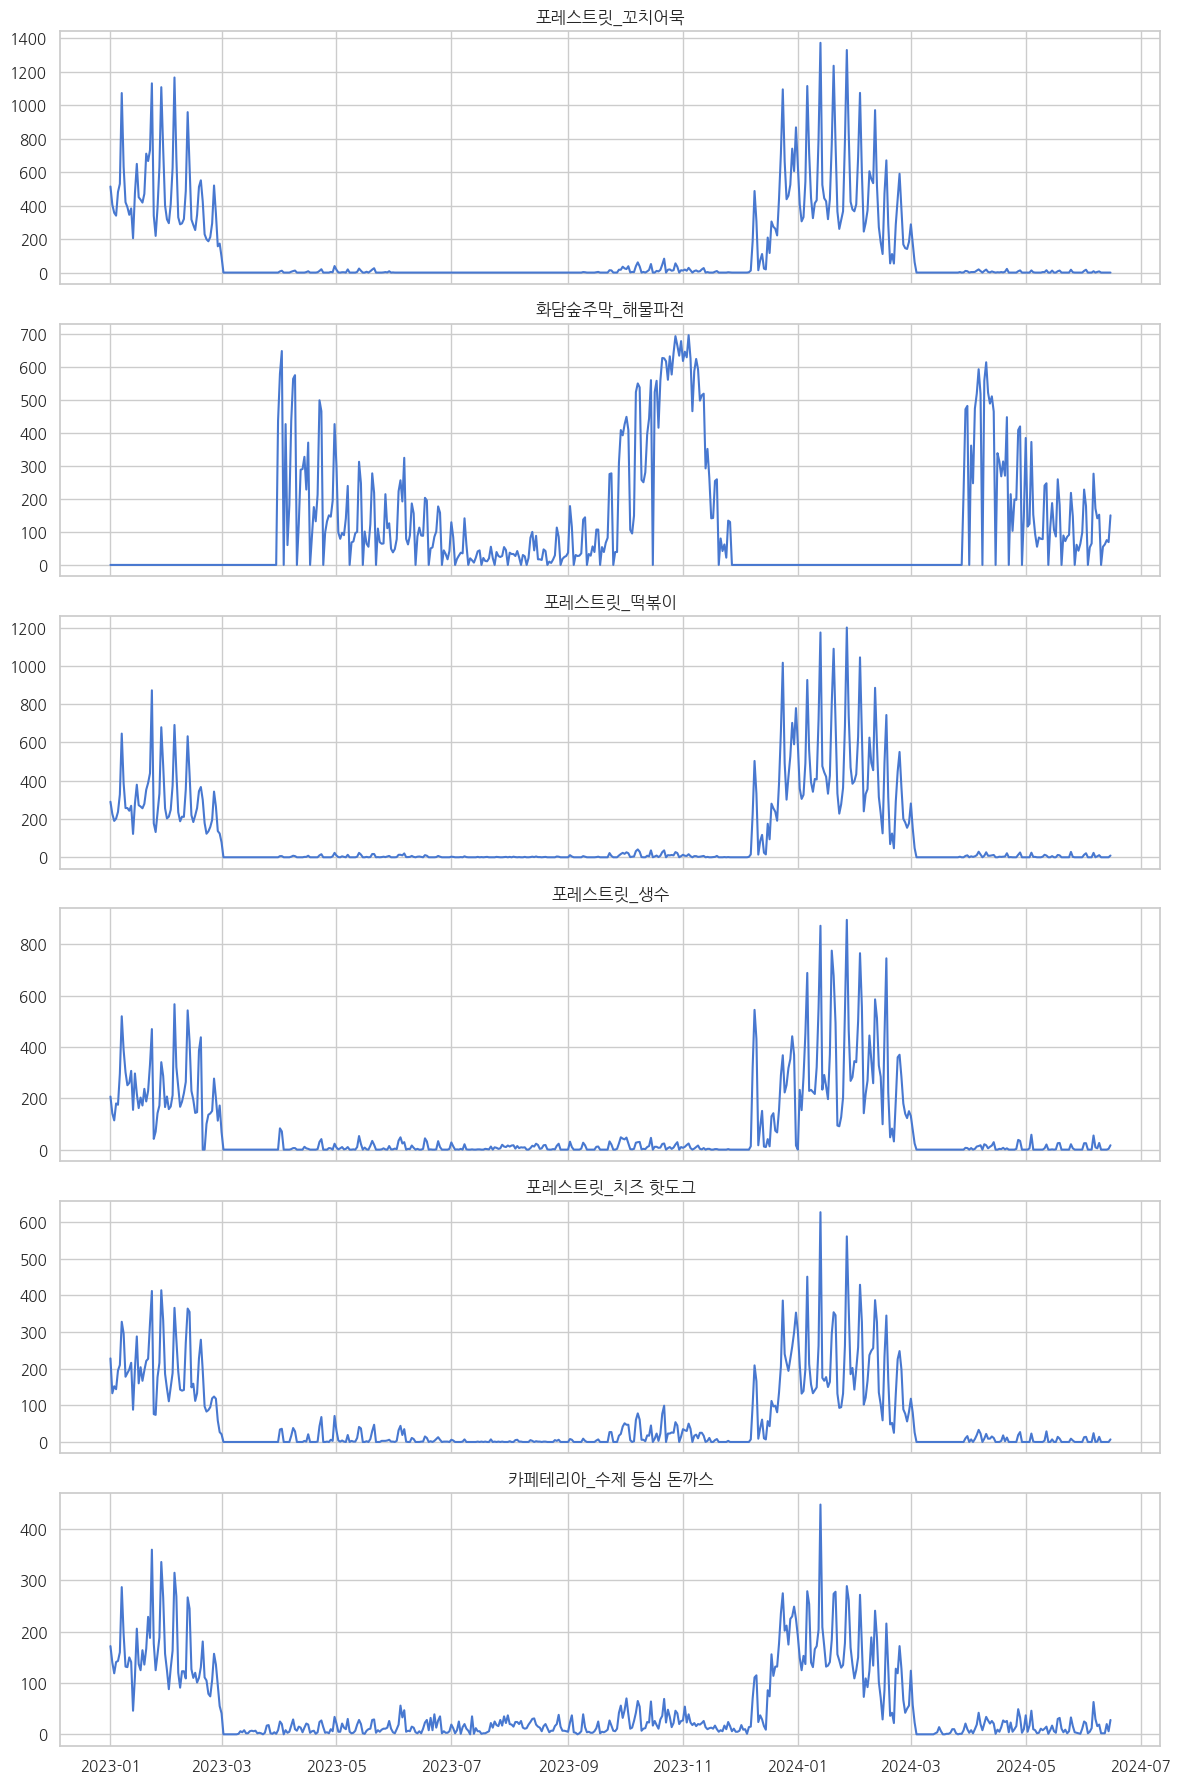

In [ ]:
# 상위 6개 메뉴 시계열
train['store_menu'] = train['store'] + '_' + train['menu']
top_n = menu_stats.sort_values('total', ascending=False).head(6)
top_n_names = (top_n['store'] + '_' + top_n['menu']).tolist()

fig, axes = plt.subplots(len(top_n_names), 1, figsize=(12, 3*len(top_n_names)), sharex=True)
for ax, menu_name in zip(axes, top_n_names):
    dd = train[train['store_menu'] == menu_name].sort_values('date')
    dd_daily = dd.groupby('date')['sales_qty'].sum().reset_index()
    ax.plot(dd_daily['date'], dd_daily['sales_qty'], label=menu_name)
    ax.set_title(menu_name)
plt.tight_layout()
plt.show()

,store,sum,mean,std
6,포레스트릿,305434,47.843672,120.459544
5,카페테리아,240930,18.869831,42.340775
7,화담숲주막,146311,34.377585,77.623310
1,담하,124917,5.590628,13.196385
3,미라시아,98077,5.946944,20.632925
0,느티나무 셀프BBQ,69805,5.704887,19.847731
8,화담숲카페,62634,23.546617,40.939361
4,연회장,28419,2.322573,15.501511
2,라그로타,17453,1.312256,2.588013


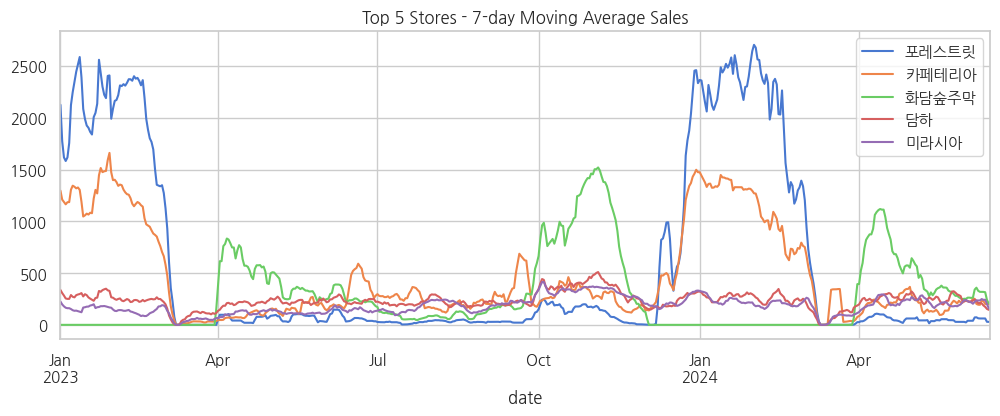

In [ ]:
# 매장별 통계
store_stats = train.groupby('store')['sales_qty'].agg(['sum', 'mean', 'std']).reset_index().sort_values('sum', ascending=False)
display(store_stats.head(10))

# 상위 5개 매장 매출 추이 (7일 이동평균)
top_stores = store_stats.head(5)['store'].tolist()
fig, ax = plt.subplots(figsize=(12, 4))
for s in top_stores:
    d = train[train['store'] == s].groupby('date')['sales_qty'].sum().rolling(7, min_periods=1).mean()
    d.plot(label=s)
plt.legend()
plt.title('Top 5 Stores - 7-day Moving Average Sales')
plt.show()

In [ ]:
# 0 비율 상위 20개 메뉴
menu_stats.sort_values('zero_ratio', ascending=False).head(20)

,store,menu,total,mean,median,std,max,min,count,zero_ratio,cv
24,담하,(단체) 생목살 김치전골 2.0,2871,5.396617,0.0,16.552565,118,0,532,0.866541,3.067211
48,담하,문막 복분자 칵테일,138,0.259398,0.0,0.898003,13,0,532,0.853383,3.461852
46,담하,명인안동소주,107,0.201128,0.0,0.571579,5,0,532,0.853383,2.841857
25,담하,(단체) 은이버섯 갈비탕,2838,5.334586,0.0,15.216234,150,0,532,0.842105,2.852373
72,라그로타,모둠 해산물 플래터,129,0.242481,0.0,0.666271,5,0,532,0.842105,2.747711
95,미라시아,공깃밥,242,0.454887,0.0,1.279946,10,0,532,0.836466,2.813760
159,카페테리아,진사골 설렁탕,4769,8.964286,0.0,23.258084,138,0,532,0.832707,2.594527
23,담하,(단체) 공깃밥,339,0.637218,0.0,3.148246,51,0,532,0.825188,4.940603
114,미라시아,잭 애플 토닉,170,0.319549,0.0,0.836634,6,0,532,0.813910,2.618163
137,연회장,마라샹궈,242,0.454887,0.0,1.076996,7,0,532,0.802632,2.367605


## LightGBM train


1.   Load data
2.   Basic cleaning
3.   Create time features & lags & rolling stats & additional stats
4.   Encode categorical
5.   Optuna를 사용하여 최적의 LightGBM 하이퍼파라미터 탐색
6.   Time-based train/val split
7.   LightGBM train with sample_weight and optimal parameters
8.   Evaluate via RMSE, save model + encoders + feature list

In [ ]:
!pip install lightgbm optuna --quiet

import os
import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.9 MB/s eta 0:00:00


In [ ]:
# 데이터 불러오기
DATA_PATH = '/content/drive/MyDrive/Lg_Aimers_data/'
OUT_PATH  = '/content/drive/MyDrive/Lg_Aimers_data/models'
train_data_path = '/content/drive/MyDrive/Lg_Aimers_data/train'


os.makedirs(OUT_PATH, exist_ok=True)

train = pd.read_csv(os.path.join(f'{train_data_path}/train.csv'))
print(train.shape)
train.head()

(102676, 3)


,영업일자,영업장명_메뉴명,매출수량
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0


In [ ]:
print((train['매출수량'] < 0).sum())
print(train['매출수량'].min(), train['매출수량'].max())
print(train.isnull().sum())
print(train['매출수량'].describe())

14
-80 1372
영업일자        0
영업장명_메뉴명    0
매출수량        0
dtype: int64
count    102676.000000
mean         10.653083
std          41.887692
min         -80.000000
25%           0.000000
50%           0.000000
75%           4.000000
max        1372.000000
Name: 매출수량, dtype: float64


In [ ]:
# 영업장명_메뉴명 분리
if '영업장명' not in train.columns:
    train['영업장명'] = train['영업장명_메뉴명'].str.split('_', expand=True)[0]
    train['메뉴명'] = train['영업장명_메뉴명'].str.split('_', expand=True)[1]

# Convert '영업일자' to datetime
train['영업일자'] = pd.to_datetime(train['영업일자'])

#날짜 파생 변수 생성
train['year'] = train['영업일자'].dt.year
train['month'] = train['영업일자'].dt.month
train['day'] = train['영업일자'].dt.day
train['dayofweek'] = train['영업일자'].dt.dayofweek
train['is_weekend'] = train['dayofweek'].isin([5,6]).astype(int)
train['weekofyear'] = train['영업일자'].dt.isocalendar().week.astype(int)

# 음수 변수 수정
train.loc[train['매출수량'] < 0, '매출수량'] = 0

In [ ]:
#시계열 특성 생성 함수
def create_lag_roll_features(df, group_cols=['영업장명','메뉴명'],
                             lags=[1,7,14], windows=[7,28]):

    df = df.sort_values(group_cols + ['영업일자']).copy()

    for lag in lags:
        #lag_n: n일 전 판매량
        df[f'lag_{lag}'] = df.groupby(group_cols)['매출수량'].shift(lag)

    for w in windows:
        #roll_mean_n: n일 이동 평균
        df[f'roll_mean_{w}'] = df.groupby(group_cols)['매출수량'].transform(
            lambda x: x.rolling(window=w, min_periods=1).mean())
        #roll_std_n: n일 이동 표준편차
        df[f'roll_std_{w}'] = df.groupby(group_cols)['매출수량'].transform(
            lambda x: x.rolling(window=w, min_periods=1).std())

    df.fillna(0, inplace=True)
    return df

#통계 기반 피처 추가 함수
def add_store_menu_stats(df):
    df = df.copy() # 원본 데이터 보존
    store_mean = df.groupby('영업장명')['매출수량'].transform('mean')
    menu_mean = df.groupby('메뉴명')['매출수량'].transform('mean')

    df['매장_평균_판매량'] = store_mean
    df['메뉴_평균_판매량'] = menu_mean

    return df

train = create_lag_roll_features(train)
train = add_store_menu_stats(train)

In [ ]:
# LabelEncoder
le_store = LabelEncoder()
le_menu = LabelEncoder()

# 영업장명, 메뉴명을 숫자 ID로 변환
train['store_id'] = le_store.fit_transform(train['영업장명'].astype(str))
train['menu_id'] = le_menu.fit_transform(train['메뉴명'].astype(str))

joblib.dump(le_store, os.path.join(OUT_PATH, 'le_store.joblib'))
joblib.dump(le_menu, os.path.join(OUT_PATH, 'le_menu.joblib'))

['/content/drive/MyDrive/Lg_Aimers_data/models/le_menu.joblib']

In [ ]:
# 가장 최근 14일간 2배, 가장 최근 한 달간 1.5배 가중치 부여
latest_date = train['영업일자'].max()

train['is_recent_2weeks'] = train['영업일자'].between(latest_date - pd.Timedelta(days=14), latest_date)
train['is_recent_month'] = train['영업일자'].between(latest_date - pd.Timedelta(days=30), latest_date)

# 가중치 설정
train['sample_weight'] = 1.0 + 2.0 * train['is_recent_2weeks'].astype(int) + 1.0 * train['is_recent_month'].astype(int)

FEATURES = [
    'lag_1','lag_7','lag_14',
    'roll_mean_7','roll_mean_28','roll_std_7','roll_std_28',
    'year', 'month', 'day', 'dayofweek', 'is_weekend', 'weekofyear',
    'store_id','menu_id',
    '매장_평균_판매량', '메뉴_평균_판매량',
]

train['target'] = train['매출수량']
train = train.dropna() # 결측치가 있는 행 삭제

X = train[FEATURES]
y = train['target']
w = train['sample_weight']

In [ ]:
# 학습 데이터/ 검증 데이터 분할
train_mask = train['영업일자'] < '2024-06-09'
val_mask = (train['영업일자'] >= '2024-06-09') & (train['영업일자'] <= '2024-06-15')

X_train, y_train, w_train = X[train_mask], y[train_mask], w[train_mask]
X_val, y_val, w_val = X[val_mask], y[val_mask], w[val_mask]

CAT_FEATURES = ['store_id', 'menu_id', 'dayofweek', 'month', 'is_weekend']

In [ ]:
# Optuna로 LightGBM 하이퍼파라미터 튜닝
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1e-1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1e-1, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1,
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
              sample_weight=w_train,
              categorical_feature=CAT_FEATURES)

    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-08-08 14:22:25,333] A new study created in memory with name: no-name-f11ff111-594b-4ca9-9723-3cc1cd4e00cd
[I 2025-08-08 14:22:27,072] Trial 0 finished with value: 13.950747103442982 and parameters: {'n_estimators': 1790, 'learning_rate': 0.09157747564659155, 'num_leaves': 68, 'max_depth': 17, 'min_child_samples': 61, 'subsample': 0.6497203779023124, 'colsample_bytree': 0.9857870689845187, 'reg_alpha': 4.716139015030324e-07, 'reg_lambda': 2.13210326051699e-06}. Best is trial 0 with value: 13.950747103442982.
[I 2025-08-08 14:22:34,867] Trial 1 finished with value: 14.104472040357507 and parameters: {'n_estimators': 2766, 'learning_rate': 0.012481620140530529, 'num_leaves': 28, 'max_depth': 13, 'min_child_samples': 63, 'subsample': 0.8966525806813666, 'colsample_bytree': 0.9376993038074699, 'reg_alpha': 0.02638772321883383, 'reg_lambda': 0.00011681698660739276}. Best is trial 0 with value: 13.950747103442982.
[I 2025-08-08 14:22:39,521] Trial 2 finished with value: 14.01471574767

Best RMSE: 13.428256015148168
Best hyperparameters: {'n_estimators': 1966, 'learning_rate': 0.08722758722971166, 'num_leaves': 98, 'max_depth': 6, 'min_child_samples': 44, 'subsample': 0.7486044662060927, 'colsample_bytree': 0.6091350487923508, 'reg_alpha': 1.884612102854862e-06, 'reg_lambda': 0.0069716692102367835}


In [ ]:
#  최적의 하이퍼파라미터로 모델 학습
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'
best_params['boosting_type'] = 'gbdt'
best_params['seed'] = 42
best_params['verbosity'] = -1

bst = lgb.train(
    best_params,
    lgb.Dataset(X_train, label=y_train, weight=w_train, categorical_feature=CAT_FEATURES),
    valid_sets=[lgb.Dataset(X_train, label=y_train, weight=w_train, categorical_feature=CAT_FEATURES),
                lgb.Dataset(X_val, label=y_val, reference=lgb.Dataset(X_train, label=y_train, weight=w_train, categorical_feature=CAT_FEATURES), weight=w_val)],
    num_boost_round=best_params.get('n_estimators',1966),
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=100)]
)

y_pred = bst.predict(X_val, num_iteration=bst.best_iteration)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Final Validation RMSE:", rmse)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's rmse: 12.1024	valid_1's rmse: 13.4283
Final Validation RMSE: 13.428256015148168


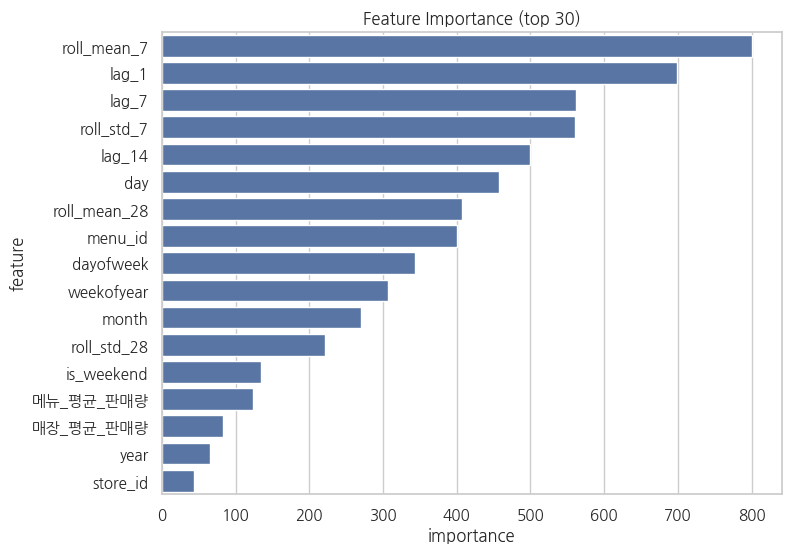

In [ ]:
# Feature importance
imp = pd.DataFrame({
    'feature': bst.feature_name(),
    'importance': bst.feature_importance()
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=imp.head(30), x='importance', y='feature')
plt.title('Feature Importance (top 30)')
plt.show()

In [ ]:
# Save model & feature list
model_path = os.path.join(OUT_PATH, 'lgb_best_model.txt')
bst.save_model(model_path)
joblib.dump(FEATURES, os.path.join(OUT_PATH, 'features_list.joblib'))

print("Saved model:", model_path)

Saved model: /content/drive/MyDrive/Lg_Aimers_data/models/lgb_best_model.txt


## 테스트 및 제출 파일 생성

In [ ]:
import pandas as pd
import numpy as np
import joblib
import os
import glob
import lightgbm as lgb
from tqdm import tqdm

In [ ]:
OUT_PATH  = '/content/drive/MyDrive/Lg_Aimers_data/models'
TEST_PATH = "/content/drive/MyDrive/Lg_Aimers_data/test"

In [ ]:
# 시계열 특성 생성 함수
def create_lag_roll_features(df, group_cols=['영업장명','메뉴명'],
                             lags=[1,7,14], windows=[7,28]):
    df = df.sort_values(group_cols + ['영업일자']).copy()

    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(group_cols)['매출수량'].shift(lag)

    for w in windows:
        df[f'roll_mean_{w}'] = df.groupby(group_cols)['매출수량'].transform(
            lambda x: x.rolling(window=w, min_periods=1).mean())
        df[f'roll_std_{w}'] = df.groupby(group_cols)['매출수량'].transform(
            lambda x: x.rolling(window=w, min_periods=1).std())

    df.fillna(0, inplace=True)
    return df

# 통계 기반 피처 추가 함수
def add_store_menu_stats(df):
    df = df.copy()
    store_mean = df.groupby('영업장명')['매출수량'].transform('mean')
    menu_mean = df.groupby('메뉴명')['매출수량'].transform('mean')
    df['매장_평균_판매량'] = store_mean
    df['메뉴_평균_판매량'] = menu_mean
    return df

# 테스트셋 전처리 함수
def preprocess_test_input(test_df, le_store, le_menu):
    if '영업장명' not in test_df.columns:
        test_df['영업장명'] = test_df['영업장명_메뉴명'].str.split('_', expand=True)[0]
        test_df['메뉴명'] = test_df['영업장명_메뉴명'].str.split('_', expand=True)[1]

    test_df['영업일자'] = pd.to_datetime(test_df['영업일자'])
    test_df['year'] = test_df['영업일자'].dt.year
    test_df['month'] = test_df['영업일자'].dt.month
    test_df['day'] = test_df['영업일자'].dt.day
    test_df['dayofweek'] = test_df['영업일자'].dt.dayofweek
    test_df['is_weekend'] = test_df['dayofweek'].isin([5, 6]).astype(int)
    test_df['weekofyear'] = test_df['영업일자'].dt.isocalendar().week.astype(int)

    test_df.loc[test_df['매출수량'] < 0, '매출수량'] = 0

    return test_df

# 피처 목록
def get_feature_columns():
    return [
        'year', 'month', 'day', 'dayofweek', 'is_weekend', 'weekofyear',
        'lag_1', 'lag_7', 'lag_14',
        'roll_mean_7', 'roll_mean_28',
        'roll_std_7', 'roll_std_28',
        '매장_평균_판매량', '메뉴_평균_판매량',
        'store_id', 'menu_id'
    ]

In [ ]:
def convert_to_submission_format(pred_df: pd.DataFrame, sample_submission: pd.DataFrame):
    pred_dict = dict(zip(
        zip(pred_df['영업일자'], pred_df['영업장명_메뉴명']),
        pred_df['매출수량']
    ))

    final_df = sample_submission.copy()

    for row_idx in final_df.index:
        date = final_df.loc[row_idx, '영업일자']
        for col in final_df.columns[1:]:  # 메뉴명들
            value = pred_dict.get((date, col), 0)
            final_df.loc[row_idx, col] = value

    return final_df


In [ ]:
if __name__ == '__main__':
    # 1. 데이터 로드
    test_files = sorted(glob.glob(os.path.join(TEST_PATH, 'TEST_*.csv')))
    test_list = []
    for file in test_files:
        df = pd.read_csv(file)
        test_list.append(df)
    test = pd.concat(test_list, ignore_index=True)

    print(test.columns)
    print(test.head())

    # 2. 전처리: LabelEncoder 불러오기
    le_store = joblib.load(os.path.join(OUT_PATH, 'le_store.joblib'))
    le_menu = joblib.load(os.path.join(OUT_PATH, 'le_menu.joblib'))

    # 3. 전처리 적용
    test = preprocess_test_input(test, le_store, le_menu)
    test = create_lag_roll_features(test)
    test = add_store_menu_stats(test)
    test['store_id'] = le_store.transform(test['영업장명'].astype(str))
    test['menu_id'] = le_menu.transform(test['메뉴명'].astype(str))

    # 4. 모델 로드
    model = lgb.Booster(model_file=os.path.join(OUT_PATH, 'lgb_best_model.txt'))

    # 5. 예측
    features = get_feature_columns()
    test['pred'] = model.predict(test[features])

    # 예측값 음수 방지
    test['pred'] = test['pred'].apply(lambda x: max(x, 0))
    pred_df = test[['영업일자', '영업장명_메뉴명']].copy()
    pred_df['매출수량'] = test['pred']
    print(test['pred'].describe())

    print(pred_df.head())
    print(sample_submission.columns[:10])
    print(pred_df['영업일자'].dtype)

    # 6. 제출 파일 생성
    sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
    submission = convert_to_submission_format(
        pred_df=test.rename(columns={'pred': '매출수량'}),
        sample_submission=sample_submission
    )

    submission.to_csv(os.path.join(OUT_PATH, 'submission_0808.csv'), index=False, encoding='utf-8-sig')
    print("✅저장 완료!")


Index(['영업일자', '영업장명_메뉴명', '매출수량'], dtype='object')
         영업일자            영업장명_메뉴명  매출수량
0  2024-06-16  느티나무 셀프BBQ_1인 수저세트     2
1  2024-06-17  느티나무 셀프BBQ_1인 수저세트     0
2  2024-06-18  느티나무 셀프BBQ_1인 수저세트     0
3  2024-06-19  느티나무 셀프BBQ_1인 수저세트     0
4  2024-06-20  느티나무 셀프BBQ_1인 수저세트     4
count    54040.00000
mean         8.08792
std         14.92621
min          0.00000
25%          0.00000
50%          0.73391
75%          9.44833
max        106.07413
Name: pred, dtype: float64
        영업일자            영업장명_메뉴명  매출수량
0 2024-06-16  느티나무 셀프BBQ_1인 수저세트   0.0
1 2024-06-17  느티나무 셀프BBQ_1인 수저세트   0.0
2 2024-06-18  느티나무 셀프BBQ_1인 수저세트   0.0
3 2024-06-19  느티나무 셀프BBQ_1인 수저세트   0.0
4 2024-06-20  느티나무 셀프BBQ_1인 수저세트   0.0
Index(['영업일자', '느티나무 셀프BBQ_1인 수저세트', '느티나무 셀프BBQ_BBQ55(단체)',
       '느티나무 셀프BBQ_대여료 30,000원', '느티나무 셀프BBQ_대여료 60,000원',
       '느티나무 셀프BBQ_대여료 90,000원', '느티나무 셀프BBQ_본삼겹 (단품,실내)',
       '느티나무 셀프BBQ_스프라이트 (단체)', '느티나무 셀프BBQ_신라면', '느티나무 셀프BBQ_쌈야채세트'],
      dtype='object')
datetim

In [ ]:
print(pred_df.head())
print(pred_df.dtypes)


        영업일자            영업장명_메뉴명  매출수량
0 2024-06-16  느티나무 셀프BBQ_1인 수저세트   0.0
1 2024-06-17  느티나무 셀프BBQ_1인 수저세트   0.0
2 2024-06-18  느티나무 셀프BBQ_1인 수저세트   0.0
3 2024-06-19  느티나무 셀프BBQ_1인 수저세트   0.0
4 2024-06-20  느티나무 셀프BBQ_1인 수저세트   0.0
영업일자        datetime64[ns]
영업장명_메뉴명            object
매출수량               float64
dtype: object
